# `nb07`: Expectation-Maximization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import multinomial

In [3]:
from matplotlib.patches import Ellipse

def _plot_cov(ax, cov, pos):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    w, h = 4 * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=w, height=h, 
                    angle=theta, alpha=0.25)
    ax.add_artist(ellip)

def make_plot(x, r=None, mu=None, sigma=None, ll=None):
    fig = plt.figure()
    ax = plt.axes()
    
    if r is None:
        ax.scatter(x[:, 0], x[:, 1], alpha=0.2)
    else:
        clusters = np.argmax(r, axis=1)
        ax.scatter(x[:, 0], x[:, 1], alpha=0.2, c=clusters)
    
    if mu is not None:
        ax.scatter(mu[:, 0], mu[:, 1])
        
    if sigma is not None:
        n_clusters = sigma.shape[0]
        
        for k in range(n_clusters):
            _plot_cov(ax, sigma[k], mu[k])
            
    if ll is not None:
        ax.set(title=r"$ll = {}$".format(ll))
                 
    plt.show()

In [4]:
# Load data
x = np.loadtxt("data/gmm.csv", delimiter=",")

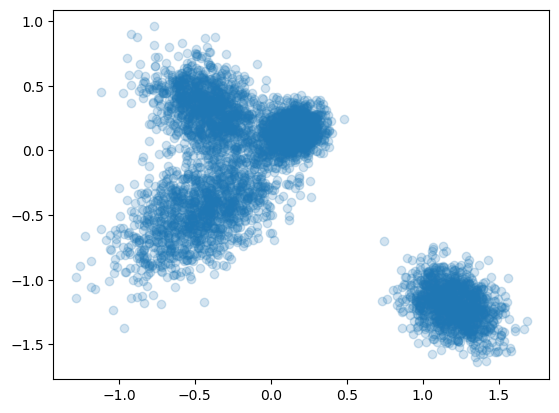

In [5]:
make_plot(x)

# Expectation-Maximization

In [6]:
# Log-likelihood p(x | pi, mu, sigma)   
def ll(x, pi, mu, sigma):
    n_samples = len(x)
    n_clusters = len(pi)
    
    l = np.zeros((n_samples, n_clusters))
    
    for k in range(n_clusters):
        l[:, k] = pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(x)
        
    return np.log(l.sum(axis=1)).mean()

In [7]:
# E-step 
def e_step(x, pi, mu, sigma):
    # Compute the posterior r[i, j] = p(z=j | x_i), for i=1->N, j=1->K
    n_samples = len(x)
    n_clusters = len(pi)

    r = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        r[:, k] = pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(x)

    r = r / np.sum(r, axis=1).reshape(-1, 1)
    
    return r

In [8]:
# M-step
def m_step(x, r):
    # Maximize E_r [ log p(x, z | pi, mu, sigma) ]
    n_samples, n_clusters = r.shape
    
    pi = np.empty(n_clusters)
    mu = np.empty((n_clusters, 2))
    sigma = np.empty((n_clusters, 2, 2))
    
    N = np.sum(r, axis=0)

    for k in range(n_clusters):
        mu[k] = np.sum(r[:, k].reshape(-1, 1) * x, axis=0) / N[k]

    for k in range(n_clusters):
        s = np.array([[0.0, 0.0], [0.0, 0.0]])

        for i in range(n_samples):
            s += r[i, k] * np.outer(x[i] - mu[k], x[i] - mu[k])

        s /= N[k]
        sigma[k] = s
        
    pi = N / n_samples
        
    return pi, mu, sigma

In [9]:
# Initialization
n_samples = len(x)
n_clusters = 4

pi = np.ones(n_clusters) / n_clusters
mu = np.random.randn(n_clusters, 2)
sigma = np.array([[1.0, 0.0], [0.0, 1.0]]) * 0.5
sigma = np.tile(sigma, [n_clusters, 1, 1])

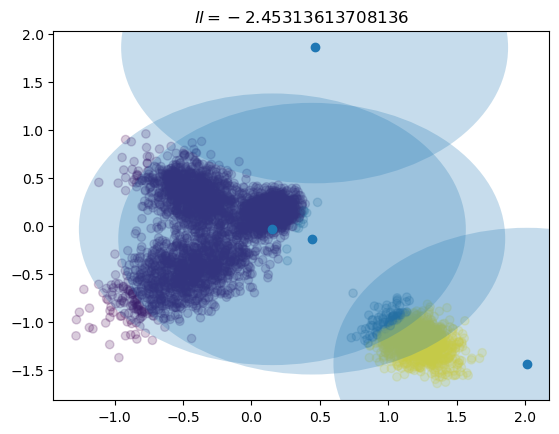

In [10]:
r = e_step(x, pi, mu, sigma)
make_plot(x, r, mu, sigma, ll=ll(x, pi, mu, sigma))

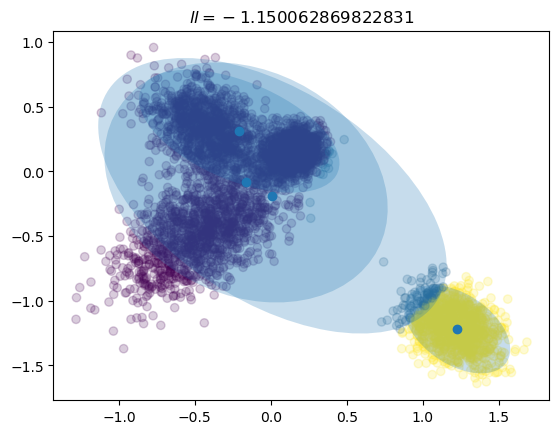

In [11]:
# Iterate manually until convergence
r = e_step(x, pi, mu, sigma)
pi, mu, sigma = m_step(x, r)
make_plot(x, r, mu, sigma, ll=ll(x, pi, mu, sigma))

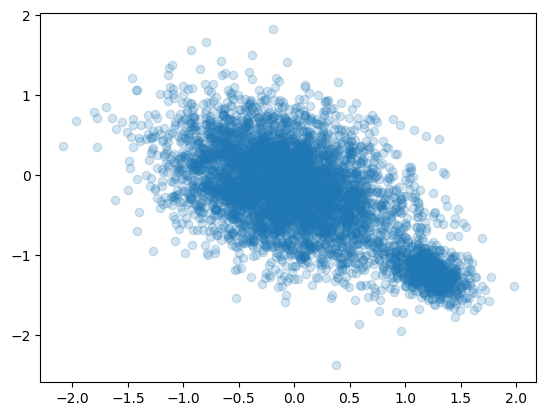

In [12]:
# Simulate new data
def simulate(n_samples, pi, mu, sigma):
    z = np.argmax(multinomial(1, pi).rvs(n_samples), axis=1)
    x = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        x[i] = multivariate_normal(mu[z[i]], sigma[z[i]]).rvs()
        
    return x

make_plot(simulate(5000, pi, mu, sigma))

# with pymc3

In [18]:

import numpy as np
import pymc3 as pm

# Simulated data
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=100)

# Define PyMC3 model
with pm.Model() as model:
    # Prior distributions
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data)
    
    # Fit the model using Maximum A Posteriori (MAP) estimation
    map_estimate = pm.find_MAP()

# Estimated parameters
print("Mean:", map_estimate['mu'])
print("Standard deviation:", map_estimate['sigma'])

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\Users\DimiP\miniconda3\envs\datascience\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ImportError: cannot import name 'asscalar' from 'numpy' (c:\Users\DimiP\miniconda3\envs\datascience\lib\site-packages\numpy\__init__.py)